#### Vit encoder 구조에 Bert encoder 구조를 참고하여 Layer Normalization 단계 추가

##### 전반적인 레포트의 목차는 다음과 같다.
0. 기존 Vit encoder 구조
1. 아이디어 (Bert)
2. encoder의 구조적 변화
3. encoder의 구조적 차이를 나타낸 그림
4. 코드상의 변화
5. 결과
6. 분석
7. 실행 코드

### 0. 기존 Vit Transformer Encoder 내부구조

  [기존 Vit 내부구조]. Transformer Encoder 내부에서는 먼저 Layer Normalization을 거치고, Multi-Head Attention을 지난 결과를 통과하지 않은 패치와 Skip Connection 시켜줍니다. 그리고 다시 Layer Nomalization, MLP를 거쳐 Skip Connection으로 다시 더해주는 것이 한 번 Transformer Encoder를 통과한 것입니다.
이러한 Transformer Encoder를 L번 반복합니다.

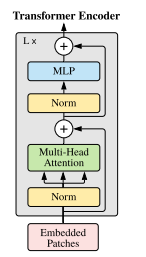

### 1. 아이디어
 Bert의 Transformer Encoder는 각 layer의 출력부 직전에 Layer Normalization을 한 뒤 출력부로 내보내는데, 이를 통해 각 인코더 층의 출력에 대해 레이어 정규화가 수행되고, 학습을 안정화하고, 그렇지 않았을 때보다 더 나은 일반화 성능을 제공할 수 있다. 이러한 Bert의 Encoder 구조를 참고해 기존 구조에서 layer 출력부에 Norm을 추가하여 변경한다.

 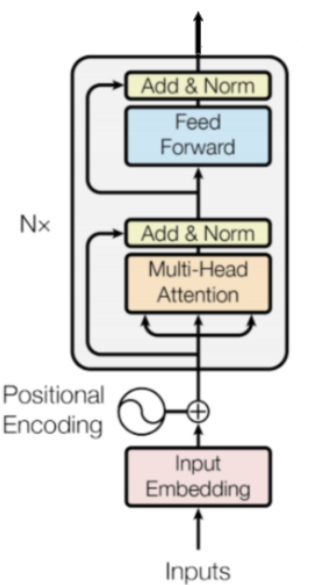

( Bert의 Transformer Encoder는 output을 추가로 Linear Norm 시켜주는데 이를 기존 Vit encoder에 적용한다. )


### 2. 기존의 Transformer Encoder의 구조와 수정한 Encoder 구조의 차이는 다음과 같다.

  [1] 기존 encoder 구조

   1) Norm

   2) Multi-Head Attention

   3) Skip Connection

   4) Norm

   5) MLP

   6) Skip Connection

  [2] 출력부에 Layer Norm을 추가한 Encoder 구조

   1) Norm

   2) Multi-Head Attention

   3) Skip Connection

   4) Norm

   5) MLP

   6) Norm (추가됨)

   7) Skip Connection




    

### 3. 수정 전, 후의 구조의 차이를 그림으로 나타내면 다음과 같다.


   [1] 기존 encoder 구조

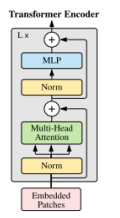


   [2] Layer Norm을 추가한 Encoder 구조

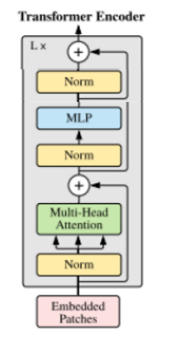

MLP에서의 output에 Layer Normalization 과정을 추가하여
layer마다 출력부에 Normalized된 결과를 얻는다.


### 4. 코드 상의 차이는 다음과 같다. (실행코드 내 def vit 부분)
실험 코드에서는 Vit 구조를 정의한 함수 내에서 encoder를 L번 반복하는 부분에 내부 encoder 구조에서 Layer Normalization 과정을 추가하기 위해   x4 = layers.LayerNormalization(epsilon=1e-6)(x3)   코드를 추가했다.
     
[1] 기존 encoder 코드
:
     
x1 = layers.LayerNormalizatio(epsilon=1e-6)(encoded_patches)       
attention_output = layers.MultiHeadAttention(                      
num_heads = num_heads, key_dim = projection_dim, dropout=0.1)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])              
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                   
x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
encoded_patches = layers.Add()([x3, x2])   

[2] Layer Norm을 추가한 Encoder 구조
(x4 과정을 한 과정 추가함)
:

x1 = layers.LayerNormalizatio(epsilon=1e-6)(encoded_patches)       
attention_output = layers.MultiHeadAttention(                      
num_heads = num_heads, key_dim = projection_dim, dropout=0.1)(x1, x1)
x2 = layers.Add()([attention_output, encoded_patches])              
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                   
x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)    
x4 = layers.LayerNormalization(epsilon=1e-6)(x3)  
encoded_patches = layers.Add()([x4, x2])

위의 수정된 코드에서 mlp를 통해 나온 x3 결과값을 layer normalization시켜 x4로 encoder 출력부를 수정하였다.

### 5. 결과

- 기존 Vit구조에서 실행한 결과와 Layer Normalization 과정을 거친 Vit구조에서 실행 결과에서의 차이를 동일하게 20epoch 이후에 각 모델의 loss와 accuracy로 비교한다.

    [1] 기존 Vit 구조에서의 결과 image.png

    [2] 수정된 Vit 구조에서의 결과 image.png

수정된 Vit 구조에서 loss가 0.2824 감소, accuracy가 0.0572로 대략 5, 6퍼센트 가량 증가했다.

- 가장 정확도가 높은 5개의 validation data의 top5-accuracy를 비교해보면 다음과 같다.

  [1] 기존 Vit구조에서의 결과 image.png

    [2] 수정된 Vit 구조에서의 결과 image.png

validation data에 대해 8퍼센트 accuracy가 향상했다.
validation data는 모델의 성능을 평가하고 조정하는 데 사용되는 데이터 세트로 학습에 사용되지 않는 더 객관적인 accuracy를 제공하는 데이터라고 할 수 있다. 주로 학습 데이터와 별도로 분리하여 모델이 학습 데이터에 overfitting되지 않도록 하고 일반화 성능을 평가한다. 따라서 validation data에서 loss 및 accuracy가 긍정적으로 변화하였으므로 해당 모델의 실제 성능이 더욱 향상했음을 알 수 있다.

기존 Vit와 Norm을 추가한 Vit구조에서 20epochs 이후의 결과에서 Loss, Accuracy는 다음과 같았다.

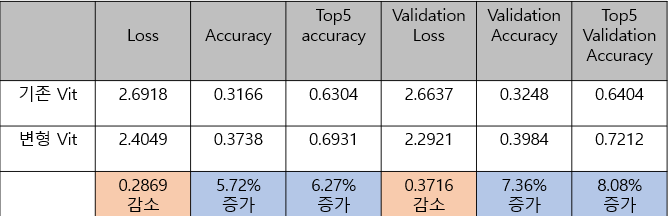

- 위의 결과를 그래프를 통해 비교하면 다음과 같다.

  [1] 기존 Vit 구조에서의 결과 그래프

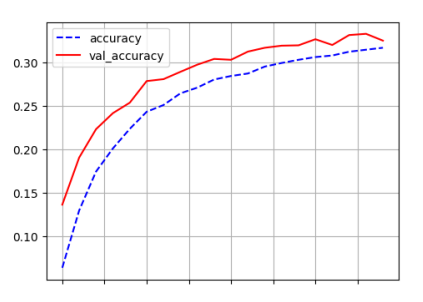


  [2] 수정된 Vit 구조에서의 결과 그래프

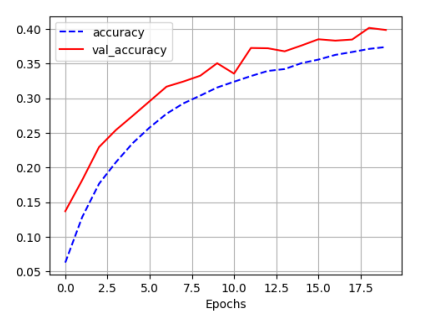

Layer Normalization을 추가했을 때, 대폭 성능이 향상된 것은 아니지만 그래프를 통해서 알 수 있듯 training data에 대한 accuracy와 validation data에 대한 accuracy 모두 증가하였다.
20epoch 기준으로, 기존의 Vit구조에서는 정확도가 30%에서 35%, 수정된 Vit 구조에서는 35%에서 40% 가량으로 소폭 상승했고 특히 validation data는 40% 이상의 정확도를 가지기도 했다.

### 6. 분석

기존의 Vit Encoder 구조에서 MLP 이후에 Layer Normalization 과정을 추가하였을 때, 정확도가 5%에서 8%까지 향상되었다.

이러한 결과의 이유를 다음과 같이 분석할 수 있다.
- MLP는 비선형성 변환으로 모델의 표현력을 증가시키는 반면, 출력 분포를 변화시키는 단계이므로 학습결과의 불안정성이 높아지게 된다. MLP 이후에 Layer Normalization 과정을 추가하여 출력을 정규화하고, 이를 통해 모델을 안정화시켜 성능의 소폭 향상되었을 것이다.

- MLP의 출력 결과는 출력들이 서로 다른 특성을 지닐 때 Internal Covariate Shift 문제가 발생할 수 있는데, 매번 Encoder를 거칠 때마다 Layer Normalization을 통해 각 레이어의 분포를 안정화시켜 이러한 문제를 해결할 수 있을 것이다.
이 때, Covariate Shift란 딥러닝 모델에서 학습 중에 각 미니배치에 대한 입력 데이터 분포가 변하는 현상을 나타내는데, 이는 학습 과정에서 모델의 파라미터가 업데이트될 때 발생할 수 있다. 딥러닝 모델은 데이터의 분포에 매우 민감하여 학습 초기에는 일정한 분포를 갖는 입력 데이터에 대해 모델이 효과적으로 학습될 수 있지만, 학습이 진행되면서 파라미터가 업데이트되면서 각 층의 활성화 값이나 출력 분포가 변화한다. 이를 해결할 수 있는 것이 Layer Normalization이며 따라서 이러한 구조를 추가했을 때, 보다 향상된 학습 결과를 얻게 된 것으로 분석할 수 있다.

### 7. 구현 코드

구현할 모델에서는 Layer의 개수를 12개, D의 크기를 64, MLP의 크기를 1024, Head 개수를 4로 설정하여 진행한다.

In [1]:
# tensorflow_addons를 사용하기 위해 설치해줘야 한다.
%pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers          # vision transformer를 구성하는데 사용 (vit함수)
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
print(tf.__version__)   # tensorflow 2.14.0 버전을 사용한다.

2.14.0


데이터는 cifar100을 사용한다.
32 x 32 크기의 60000개의 이미지로 이루어져 있으며, 100개의 클래스로 분류(dolphin, fish ...) 되며 각각의 클래스는 600개의 이미지로 이루어져 있다.
또, 500개는 학습 데이터, 100개는 데이터 데이터로 이루어져 있어 총 50000개의 학습 데이터, 10000개의 테스트 데이터로 이루어져있다.

In [4]:
#  0 사용하므로 class를 100개로 지정
input_shape = (32,32,3)   # input shape는 32x32의 RGB 채널을 가진 이미지이다.

# 데이터 로드 (train과 test를 나눠서 로드한다)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")

169001437/169001437 [==============================] - 4s 0us/step
x_train shape : (50000, 32, 32, 3), y_train shape : (50000, 1)
x_test shape : (10000, 32, 32, 3), y_test shape : (10000, 1)


In [5]:
batch_size = 256

image_size = 224    # 16x16 이미지를 업사이징하여 224x224로 만들것이다.
patch_size = 32     # 패치 사이즈는 32x32,
num_patches = (image_size//patch_size)**2     # 패치의 개수는 이미지 크기를 패치사이즈로 나누고 제곱한다.

# D 차원으로 벡터화
projection_dim = 64   # D = 64
num_heads = 4

# mlp에서 사용하는 transformer unit (128, 64)
transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12         # layer의 개수
mlp_head_units = [2048, 1024]

In [6]:
# 이미지 업사이징, 전처리
data_augmentation = keras.Sequential(
    [
            layers.Normalization(),                         # Normalize
            layers.Resizing(image_size, image_size),        # 224 x 224
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = 'data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

In [7]:
# mlp 함수
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
      x = layers.Dense(units, activation=tf.nn.gelu)(x)   # 활성화함수로 gelu를 사용
      x = layers.Dropout(dropout_rate)(x)                 # dropout을 사용한다.
  return x

In [8]:
# 패치화하는 클래스
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = "VALID",    # padding 사용 X
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

In [9]:
# PatchEncoder를 class로 정의
# (Linear Projection -> Position Embedding)
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)      # D차원으로 Linear Projection
    self.position_embedding = layers.Embedding(               # position embedding
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)          # 0부터 patch개수만큼 1씩 증가하는 position
    encoded = self.projection(patch) + self.position_embedding(positions)   # position embedding 과정
    return encoded  # z0

In [10]:
# vision transformer 구조를 정의하는 부분이다. 여기서 mlp를 통해 나온 x3를 Layer Normalization 시켜, x4를 출력한다.
def vit():

  # 1) Patch화 ->  patch를 Linear Projection -> Position Embedding
  inputs = layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)     # inputs를 업사이징
  patches = Patches(patch_size)(augmented)  # patch 생성 (patches)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # patch를 Linear Projection -> Position Embedding


  # 2) Transformer Encoder L번 반복
  for _ in range(transformer_layers):   # L번 반복

    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)       # 2) Layer Normalize

    attention_output = layers.MultiHeadAttention(                       # 1) Multi-Head Attention
        num_heads = num_heads, key_dim = projection_dim, dropout=0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])              # 3) Skip Connection


    x3 = mlp(x2, hidden_units = transformer_units, dropout_rate = 0.1)  # 5) MLP


    ############### 코드 추가 #################
    x4 = layers.LayerNormalization(epsilon=1e-6)(x3)                    # 4) Layer Normalize
    ###########################################


    encoded_patches = layers.Add()([x4, x2])                            # 6) Skip Connection



  # 3) MLP Head에 들어가기 전 레이어정규화
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  # 4) MLP Head
  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)

  # 5) class화
  logits = layers.Dense(100)(features)

  # 6) 모델 생성
  model = keras.Model(inputs=inputs, outputs = logits)

  return model

In [11]:
model = vit()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches (Patches)           (None, None, 3072)           0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 49, 64)               199808    ['patches[0][0]']         

In [12]:
# 학습 / 테스트
num_epochs = 20
weight_decay = 0.001
learning_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
    ],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size = batch_size,
    epochs = num_epochs,
    validation_split = 0.1,
)

Epoch 1/20
176/176 [==============================] - 59s 207ms/step - loss: 4.3034 - accuracy: 0.0617 - top-5-accuracy: 0.2004 - val_loss: 3.7390 - val_accuracy: 0.1348 - val_top-5-accuracy: 0.3606
Epoch 2/20
176/176 [==============================] - 35s 200ms/step - loss: 3.7196 - accuracy: 0.1264 - top-5-accuracy: 0.3589 - val_loss: 3.4099 - val_accuracy: 0.1848 - val_top-5-accuracy: 0.4464
Epoch 3/20
176/176 [==============================] - 34s 194ms/step - loss: 3.4331 - accuracy: 0.1757 - top-5-accuracy: 0.4440 - val_loss: 3.1642 - val_accuracy: 0.2294 - val_top-5-accuracy: 0.5090
Epoch 4/20
176/176 [==============================] - 34s 193ms/step - loss: 3.2428 - accuracy: 0.2063 - top-5-accuracy: 0.4925 - val_loss: 3.0180 - val_accuracy: 0.2510 - val_top-5-accuracy: 0.5454
Epoch 5/20
176/176 [==============================] - 34s 194ms/step - loss: 3.1064 - accuracy: 0.2338 - top-5-accuracy: 0.5289 - val_loss: 2.9682 - val_accuracy: 0.2602 - val_top-5-accuracy: 0.5638
Epoch

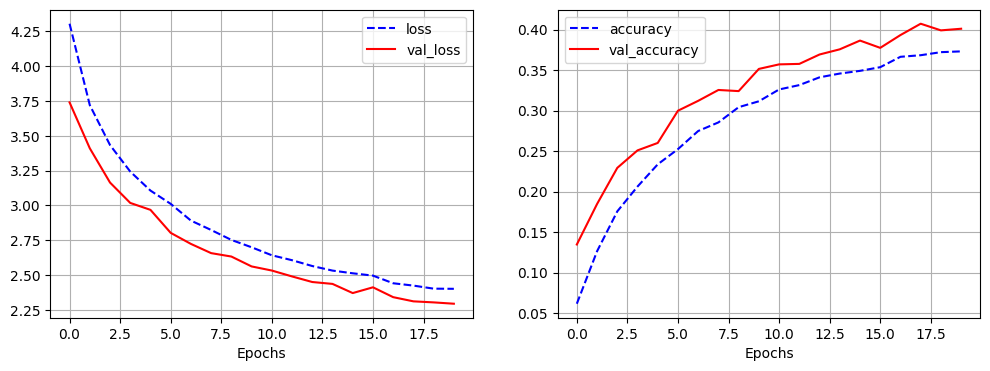

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()